In [53]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [54]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [55]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [56]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=45,
        output_chunk_length=1,
        activation="GELU",
        num_layers=1,
        num_blocks=4,
        num_stacks=3,
        layer_widths=243,
        n_epochs=100,
        batch_size=104,
        dropout=0.1300946376042601,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.00011494227662736073, "weight_decay": 8.444384638688174e-05}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.063
Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.041
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.040
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.024
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.024. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    33.077210    5.751279    4.045752  0.340645   
Precipitation_accumulated       0.219741    0.468766    0.316329  0.655367   
Humidity                      121.437793   11.019882    8.693999  0.617419   
Wind_Speed_kmh                  0.795184    0.891731    0.745646 -0.861733   
Soil_Moisture              237855.796087  487.704620  348.753932  0.621212   
Soil_Temperature               31.851931    5.643752    4.731995  0.561963   
Wind_Dir_Sin                    0.371751    0.609714    0.481955 -0.153793   
Wind_Dir_Cos                    0.616053    0.784890    0.634813 -0.646295   

                                SMAPE  
Temperature                 23.095761  
Precipitation_accumulated    9.544640  
Humidity                    15.597909  
Wind_Speed_kmh              63.578590  
Soil_Mo

Metric val_loss improved. New best score: 18.181
Metric val_loss improved by 0.614 >= min_delta = 0.001. New best score: 17.567
Metric val_loss improved by 0.839 >= min_delta = 0.001. New best score: 16.728
Metric val_loss improved by 1.177 >= min_delta = 0.001. New best score: 15.551
Metric val_loss improved by 1.636 >= min_delta = 0.001. New best score: 13.915
Metric val_loss improved by 0.295 >= min_delta = 0.001. New best score: 13.619
Metric val_loss improved by 1.075 >= min_delta = 0.001. New best score: 12.545
Metric val_loss improved by 0.887 >= min_delta = 0.001. New best score: 11.658
Metric val_loss improved by 0.725 >= min_delta = 0.001. New best score: 10.933
Metric val_loss improved by 0.215 >= min_delta = 0.001. New best score: 10.718
Metric val_loss improved by 1.106 >= min_delta = 0.001. New best score: 9.612
Metric val_loss improved by 0.564 >= min_delta = 0.001. New best score: 9.048
Monitored metric val_loss did not improve in the last 10 records. Best score: 9.048.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                9.614549e+04    310.073358    265.930542   
Precipitation_accumulated  5.604989e+03     74.866476     49.797297   
Humidity                   4.382114e+04    209.334993    164.240672   
Wind_Speed_kmh             6.173728e+03     78.573074     67.151180   
Soil_Moisture              6.727562e+08  25937.543311  22056.575874   
Soil_Temperature           5.627500e+05    750.166658    636.811459   
Wind_Dir_Sin               3.057684e+03     55.296326     47.503080   
Wind_Dir_Cos               5.676645e+02     23.825711     20.232431   

                                     R2       SMAPE  
Temperature                -2776.317781  154.665635  
Precipitation_accumulated      0.854386   16.343491  
Humidity                    -346.000035  152.787620  
Wind_Speed_kmh            -19471.811697  160.930961  


Metric val_loss improved. New best score: 0.023
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.011
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.008
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    3.409139    1.846386    1.476653  3.611797e-01   
Precipitation_accumulated   3376.723735   58.109584   54.649950 -3.034902e+07   
Humidity                      16.484745    4.060141    3.117443  4.760306e-02   
Wind_Speed_kmh                 0.331469    0.575733    0.442799          -inf   
Soil_Moisture              19706.383330  140.379426  115.741797 -1.361633e+01   
Soil_Temperature              11.752195    3.428147    2.834711 -9.350239e-01   
Wind_Dir_Sin                   0.022184    0.148942    0.121559          -inf   
Wind_Dir_Cos                   0.025067    0.158327    0.130227          -inf   

                                SMAPE  
Temperature                 10.350715  
Precipitation_accumulated   11.178840  
Humidity                     3.489739  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encount

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    2.146399    1.465059    1.148116    -2.961089   
Precipitation_accumulated    100.805396   10.040189    7.616646 -3035.877664   
Humidity                      29.422697    5.424269    4.562995    -1.967920   
Wind_Speed_kmh                 0.045759    0.213913    0.145688         -inf   
Soil_Moisture              29267.638347  171.077872  118.799131     0.102071   
Soil_Temperature               6.159939    2.481922    1.499107   -28.223967   
Wind_Dir_Sin                   0.013679    0.116958    0.078779         -inf   
Wind_Dir_Cos                   0.025622    0.160068    0.132888         -inf   

                                SMAPE  
Temperature                 13.223688  
Precipitation_accumulated    1.662510  
Humidity                     4.972788  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     2.639465    1.624643    1.365609    -0.120154   
Precipitation_accumulated    1227.275299   35.032489   28.166669 -4263.085368   
Humidity                      113.068690   10.633376    9.413248    -1.477703   
Wind_Speed_kmh                  0.135116    0.367581    0.285037   -62.944522   
Soil_Moisture              146845.880559  383.204750  346.481381   -16.968647   
Soil_Temperature                1.424223    1.193408    0.945558     0.114916   
Wind_Dir_Sin                    0.022276    0.149252    0.088783     0.620396   
Wind_Dir_Cos                    0.038025    0.195001    0.135198     0.576241   

                                SMAPE  
Temperature                 17.602048  
Precipitation_accumulated    6.443206  
Humidity                    10.765230  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.025
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     4.164089    2.040610    1.593328    0.561638   
Precipitation_accumulated     177.156877   13.310029   10.023262 -153.230785   
Humidity                       29.368448    5.419266    4.126387    0.740707   
Wind_Speed_kmh                  1.093407    1.045661    0.724885    0.297111   
Soil_Moisture              299955.780438  547.682189  460.327337    0.754149   
Soil_Temperature               24.343189    4.933882    4.384276   -3.841907   
Wind_Dir_Sin                    0.376965    0.613974    0.453365    0.221168   
Wind_Dir_Cos                    0.267810    0.517504    0.408233    0.446598   

                                SMAPE  
Temperature                 41.809407  
Precipitation_accumulated    2.187583  
Humidity                     4.590509  
Wind_Speed_kmh             10

Metric val_loss improved. New best score: 0.024
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    5.548172    2.355456    1.894318     0.793522   
Precipitation_accumulated    449.439216   21.199982   17.928980 -1675.617681   
Humidity                      50.640506    7.116214    5.726618     0.660184   
Wind_Speed_kmh                 0.731582    0.855326    0.643073     0.389808   
Soil_Moisture              21983.850387  148.269519  119.893306    -2.685489   
Soil_Temperature               3.491775    1.868629    1.466747     0.685527   
Wind_Dir_Sin                   0.425700    0.652457    0.549682     0.210221   
Wind_Dir_Cos                   0.360846    0.600704    0.512925    -0.079301   

                                SMAPE  
Temperature                 19.484616  
Precipitation_accumulated    3.950830  
Humidity                     7.002044  
Wind_Speed_kmh              6

In [57]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=4, num_layers=1, layer_widths=243, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1300946376042601, activation=GELU, MaxPool1d=True, model_name=model_1, input_chunk_length=45, output_chunk_length=1, n_epochs=100, batch_size=104, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fa11b2d4470>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0001149422766273

In [58]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


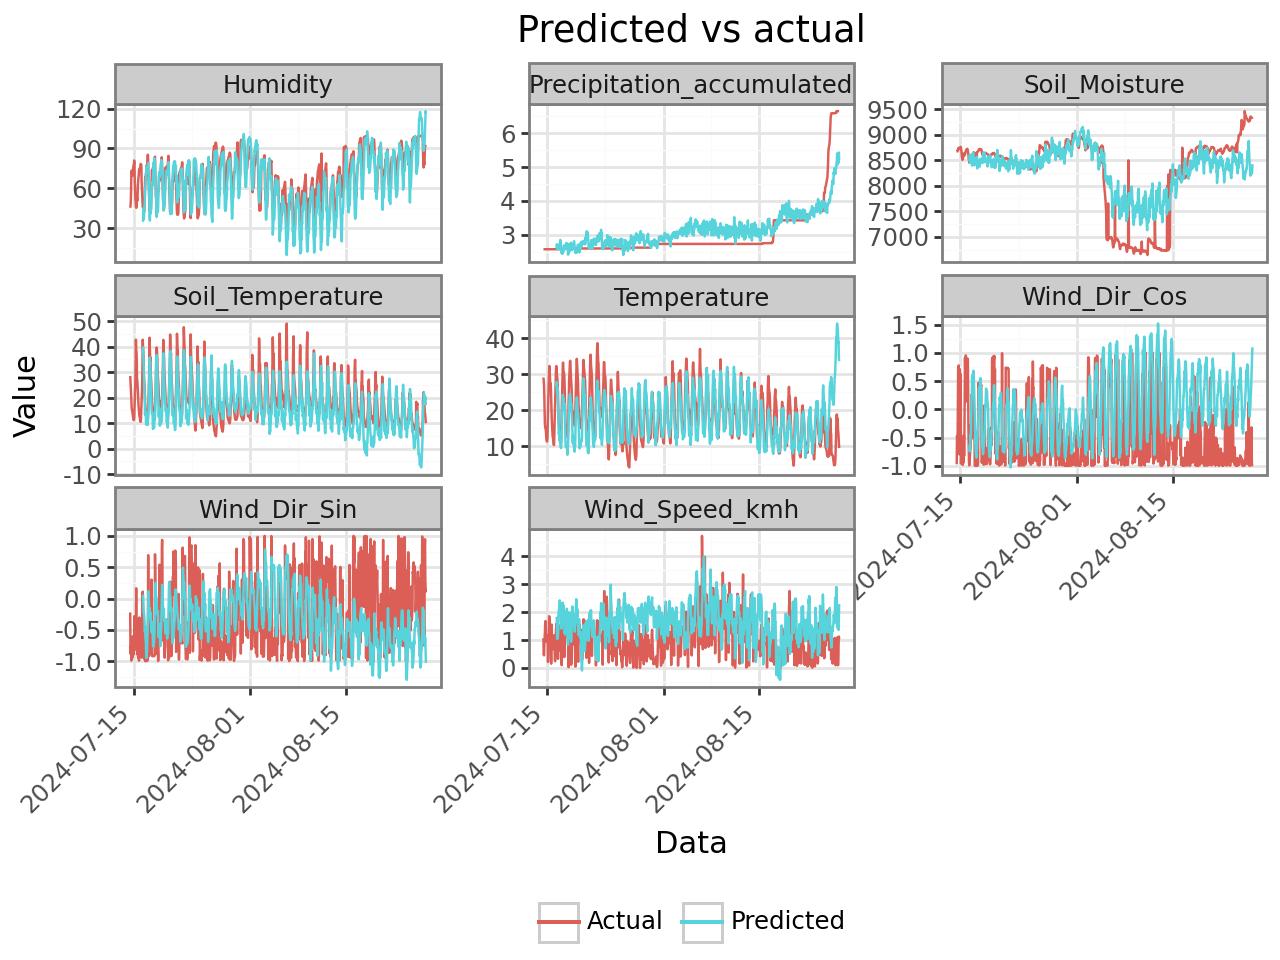

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [59]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

In [60]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

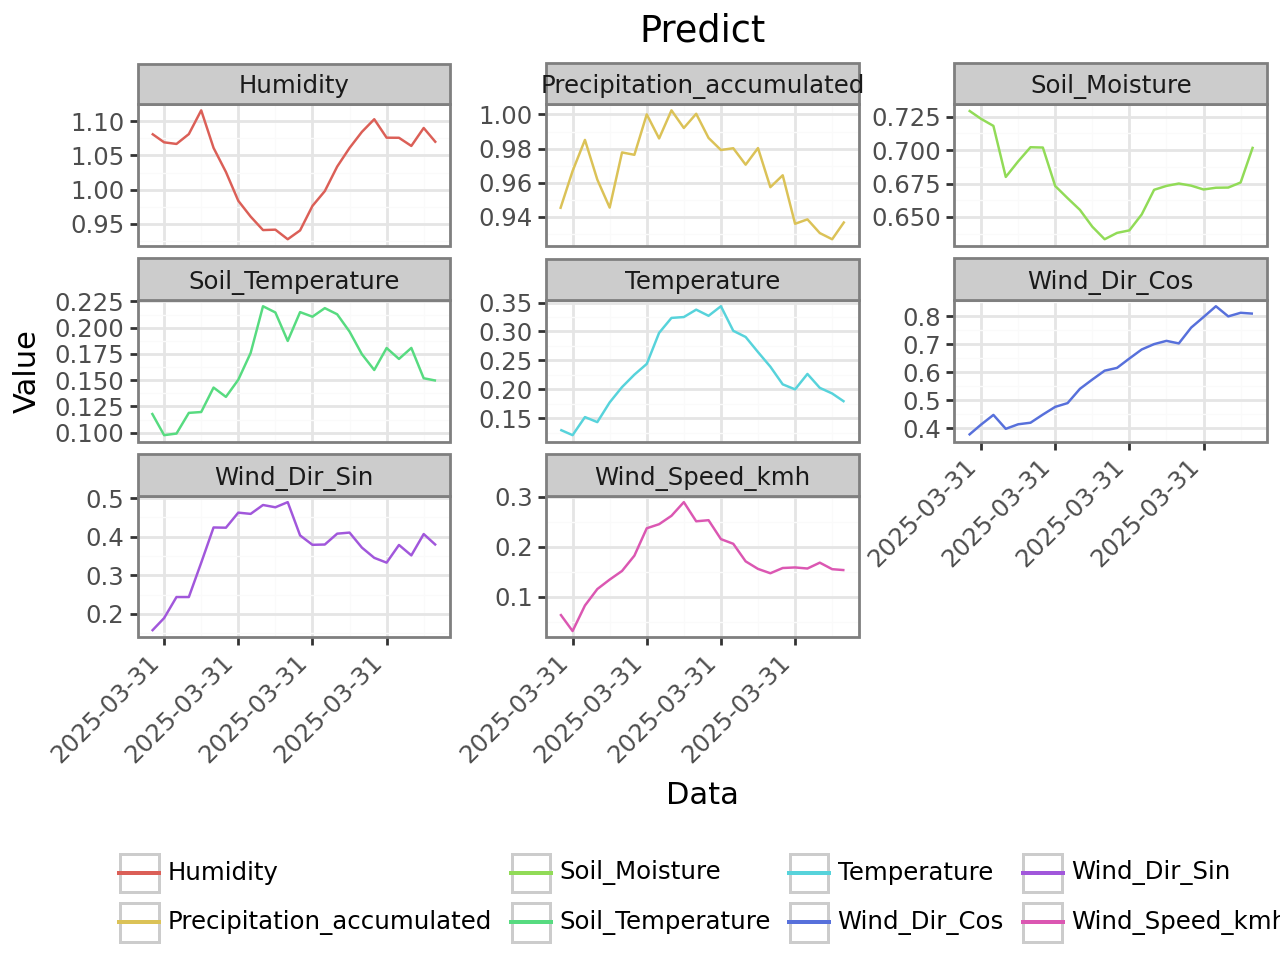

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_24.png


In [61]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Predict',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),

    )
)
plot.show()
plot.save('predict_24.png', width=12, height=10, dpi=300)

In [62]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)